In [2]:
from datasets.shapenet_part import PartNormalDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud
from models_adl4cv.pvcnn import PVCNNPartSeg, PVCNN

In [3]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:4612
Min number of points: (train)2048 (test)2048
Total number of data:662
Min number of points: (train)2048 (test)2048
Total number of data:1317
Min number of points: (train)2048 (test)2048


In [4]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(4612, 662, 1317)

In [5]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [6]:
def add_random_noise(point_cloud, mean=0, std=0.025):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [7]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [5]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=4).to("cuda")
model

PVCNN(
  (point_features): ModuleList(
    (0): PVConv(
      (voxelization): Voxelization(resolution=32)
      (voxel_layers): Sequential(
        (0): Conv3d(7, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)
        (6): SE3d(
          (fc): Sequential(
            (0): Linear(in_features=64, out_features=8, bias=False)
            (1): Swish()
            (2): Linear(in_features=8, out_features=64, bias=False)
            (3): Sigmoid()
          )
        )
      )
      (point_features): SharedMLP(
        (layers): Sequential(
          (0): Conv1d(7, 64, kernel_size=(1,), stride

In [9]:
part_model = PVCNNPartSeg(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")
part_model.load_state_dict(torch.load("output-models/pvcnn-part-segmentation-noise-chair/PVCNN-Part-Segmentation-Noise-Chair-e48.pth"))

<All keys matched successfully>

In [10]:
for batch in train_dataloader:
    input = batch["train_points"].to("cuda")
    break

In [11]:
input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
input.shape, input_seg.shape

(torch.Size([20, 2048, 3]), torch.Size([20, 2048]))

In [12]:
class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
class_labels_one_hot.shape

torch.Size([20, 2048, 4])

In [13]:
combined_tensor = torch.cat((input, class_labels_one_hot), dim=-1)

print(combined_tensor.shape)  # 

torch.Size([20, 2048, 7])


In [10]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Refinement-Part-Class-Condition-Chair'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [ ]:
# Time to train
for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda")
        
        noised_input = add_random_noise(input)
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1] # .unsqueeze(-1)

        optimizer.zero_grad()
        
        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((noised_input, class_labels_one_hot), dim=-1)

        output = model(combined_tensor.transpose(1,2)).transpose(1,2)

        loss = chamfer_distance(input[:, :1024, :], output)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    # Epoch is done; Reduce LR
    lr_scheduler.step()

    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda")
            
            # Let's first add noise
            noised_input = add_random_noise(input)

            # Let's segment the input into parts and extract the part assignment.
            input_seg = part_model(noised_input.transpose(1,2)).transpose(1,2).data.max(2)[1] # .unsqueeze(-1)
            
            # Classes in one extra feature
            # classes_input = torch.cat([noised_input, input_seg], dim=2)
            # output = model(classes_input.transpose(1,2)).transpose(1,2)

            # Normal
            # output = model(noised_input.transpose(1,2)).transpose(1,2)

            # One hot encoded
            class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
            combined_tensor = torch.cat((noised_input, class_labels_one_hot), dim=-1)
            output = model(combined_tensor.transpose(1,2)).transpose(1,2)

            val_loss = chamfer_distance(input, output)
            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-refinement-part-class-chair/PVCNN-Baseline-Refinement-Part-Class-Chair-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

In [12]:
# torch.save(optimizer.state_dict(), "./optim-ckpt.pth")

optimizer.load_state_dict(torch.load("./optim-ckpt.pth"))
epoch = 24

In [10]:
import pandas as pd

df_train = pd.read_csv("./eval-results/pvcnn-refinement-part-run-train-loss.csv")
df_val = pd.read_csv("./eval-results/pvcnn-refinement-part-run-val-loss.csv")

training_losses = df_train["Value"].to_numpy()
val_losses = df_val["Value"].to_numpy()

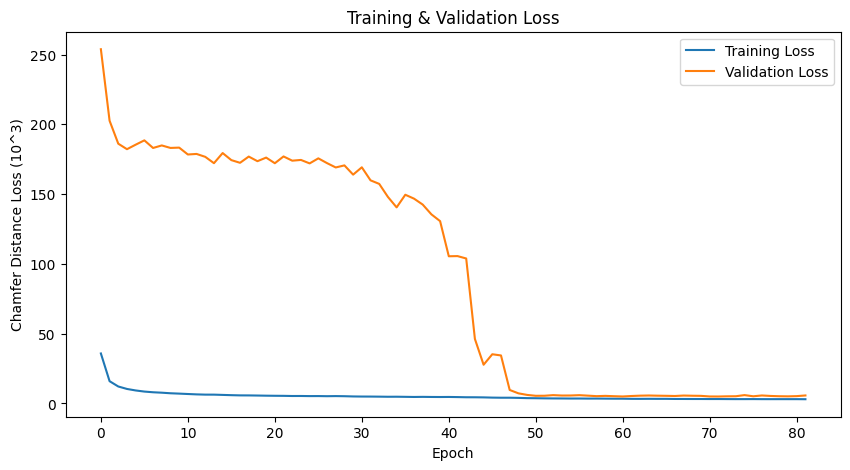

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(training_losses) * (10**3), label='Training Loss')
plt.plot(np.array(val_losses) * (10**3), label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss (10^3)')
plt.legend()
plt.show()

In [20]:
print(f"Best Train Loss: Epoch: {np.argmin(training_losses)}, Loss: {np.min(training_losses)* (10**3):.4f}")
print(f"Best Val Loss: Epoch: {np.argmin(val_losses)}, Loss: {np.min(val_losses) * (10**3):.4f}")

Best Train Loss: Epoch: 14, Loss: 7.8857
Best Val Loss: Epoch: 4, Loss: 22.5718


In [14]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=4).to("cuda")
# model.load_state_dict(torch.load(f"output-models/pvcnn-refinement-part/PVCNN-Baseline-Refinement-Part-e{np.argmax(val_losses)+1}.pth"))
model.load_state_dict(torch.load("output-models/pvcnn-refinement-part-class-chair/PVCNN-Baseline-Refinement-Part-Class-Chair-e24.pth"))

<All keys matched successfully>

In [16]:
# Test
total_test_loss = 0
batch_i=1

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input = batch["test_points"].to("cuda")
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((input, class_labels_one_hot), dim=-1)
        output = model(combined_tensor.transpose(1,2)).transpose(1,2)
        
        test_loss = chamfer_distance(input, output)
        total_test_loss += test_loss.item()
        print(f"Batch: {batch_i}; CD Loss: {test_loss.item() * 10**3:.4f}")
        batch_i+=1

avg_total_loss = total_test_loss / len(test_dataloader)
print(f"Test Loss: {avg_total_loss * 10**3:.4f}")

Batch: 1; CD Loss: 49.1267
Batch: 2; CD Loss: 57.0968
Batch: 3; CD Loss: 43.5227
Batch: 4; CD Loss: 46.2592
Batch: 5; CD Loss: 45.4488
Batch: 6; CD Loss: 43.6019
Batch: 7; CD Loss: 53.6155
Batch: 8; CD Loss: 43.4409
Batch: 9; CD Loss: 49.9809
Batch: 10; CD Loss: 50.7292
Batch: 11; CD Loss: 43.5373
Batch: 12; CD Loss: 40.7146
Batch: 13; CD Loss: 41.2633
Batch: 14; CD Loss: 65.9165
Batch: 15; CD Loss: 53.1366
Batch: 16; CD Loss: 43.5960
Batch: 17; CD Loss: 42.5909
Batch: 18; CD Loss: 47.0822
Batch: 19; CD Loss: 50.6356
Batch: 20; CD Loss: 45.7603
Batch: 21; CD Loss: 40.0394
Batch: 22; CD Loss: 57.9344
Batch: 23; CD Loss: 46.2745
Batch: 24; CD Loss: 52.5146
Batch: 25; CD Loss: 35.1089
Batch: 26; CD Loss: 54.8175
Batch: 27; CD Loss: 42.3840
Batch: 28; CD Loss: 48.0419
Batch: 29; CD Loss: 52.7145
Batch: 30; CD Loss: 44.0067
Batch: 31; CD Loss: 54.5061
Batch: 32; CD Loss: 54.5836
Batch: 33; CD Loss: 56.7108
Batch: 34; CD Loss: 39.4547
Batch: 35; CD Loss: 45.1644
Batch: 36; CD Loss: 60.5208
B

In [47]:
INDEX = 15
input_pc = rotate_point_cloud_y(input[INDEX, ...].detach().cpu().numpy(), 45)
output_pc = rotate_point_cloud_y(output[INDEX, ...].detach().cpu().numpy(), 45)
input_pc.shape, output_pc.shape

((2048, 3), (2048, 3))

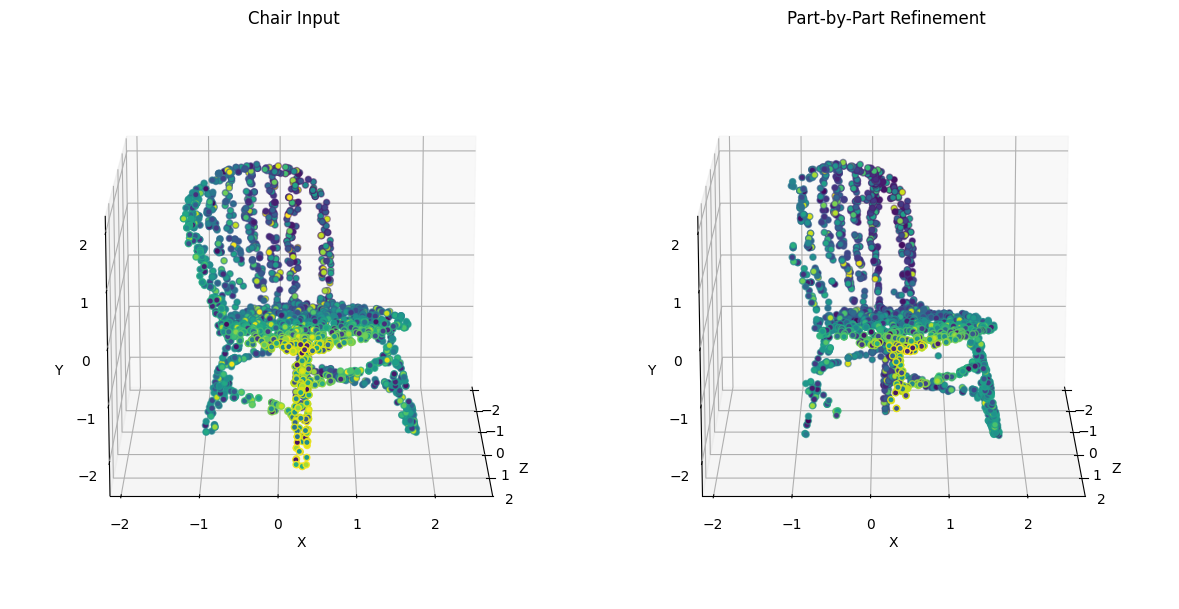

In [48]:
fig = visualize_pointcloud_eval(input_pc, output_pc, "Chair Input", "Part-by-Part Refinement")

(650, 3) 28.5961404178404
(847, 3) 29.939609142623123
(295, 3) 28.909994448057493
(256, 3) 27.347695899750097


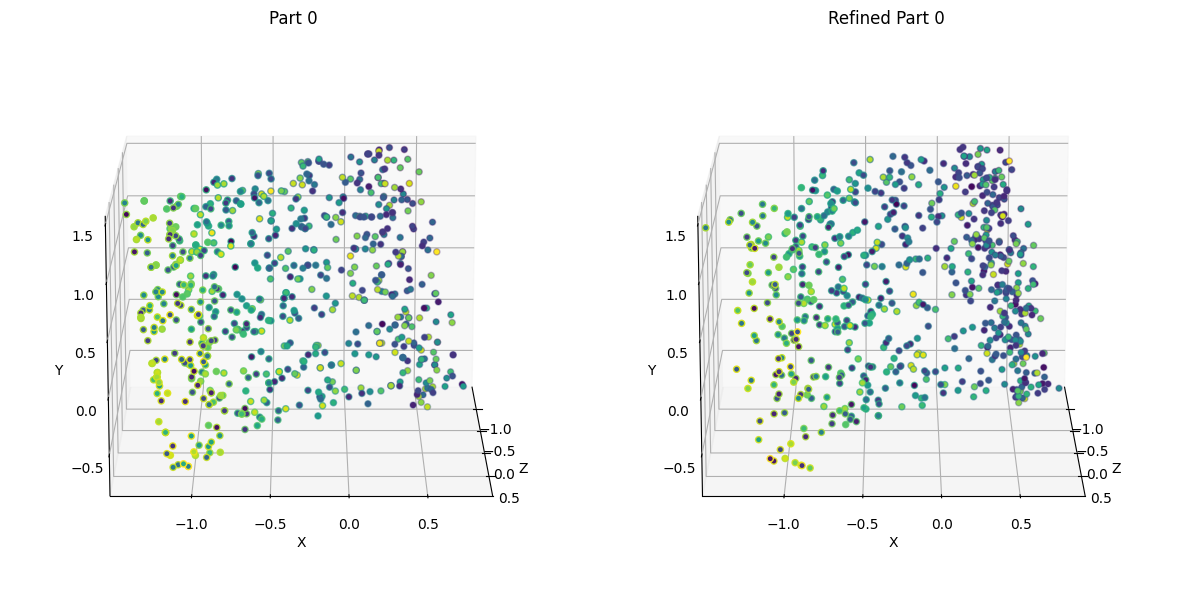

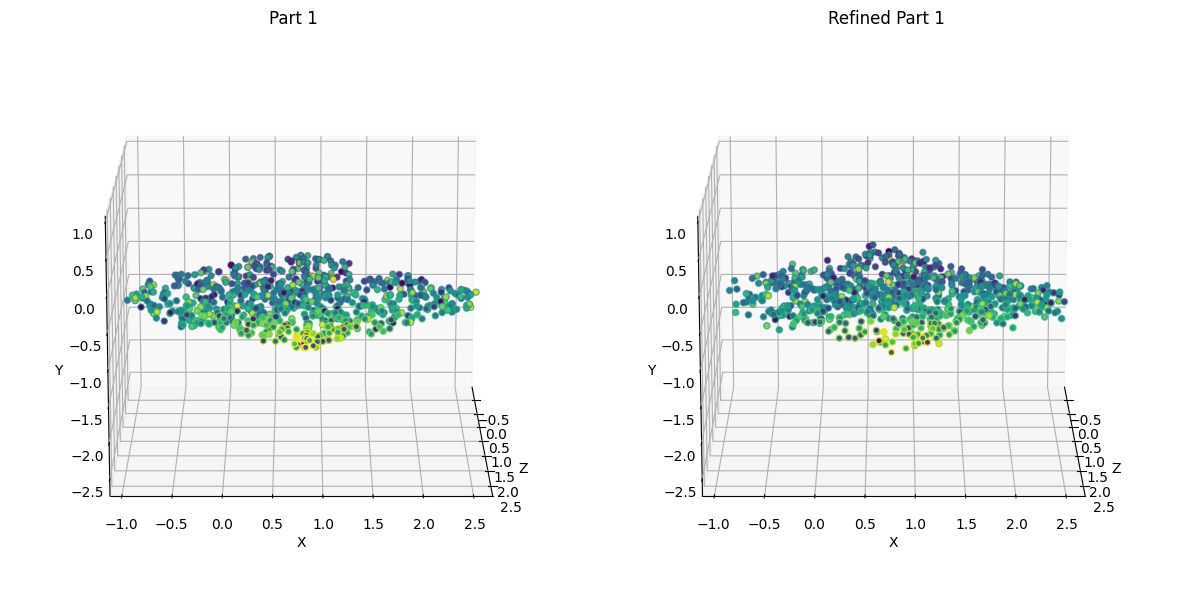

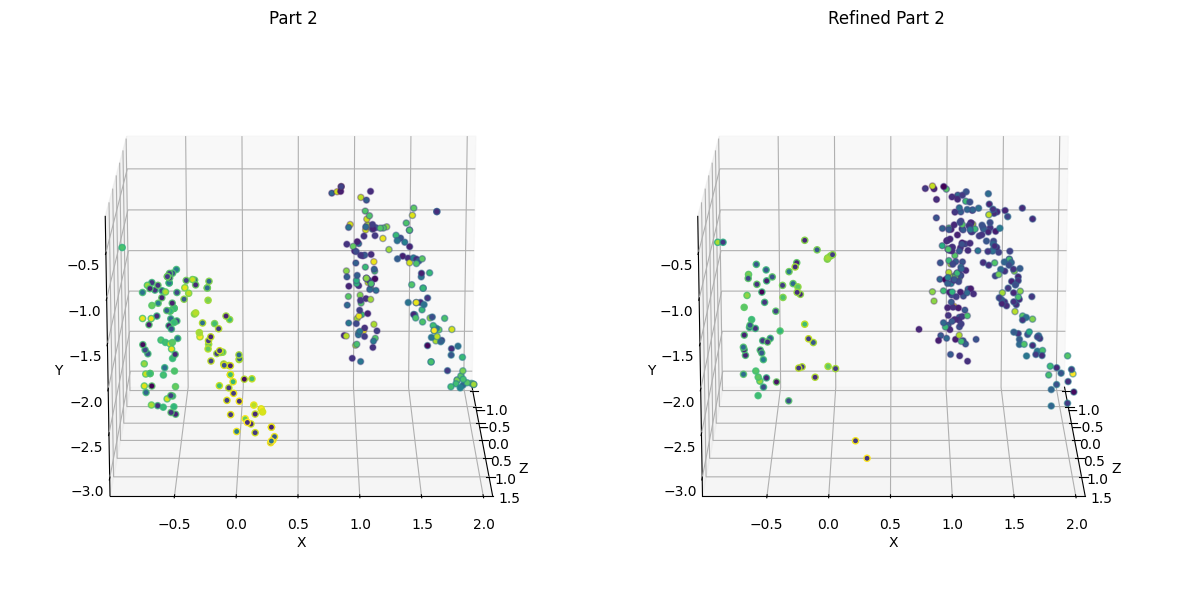

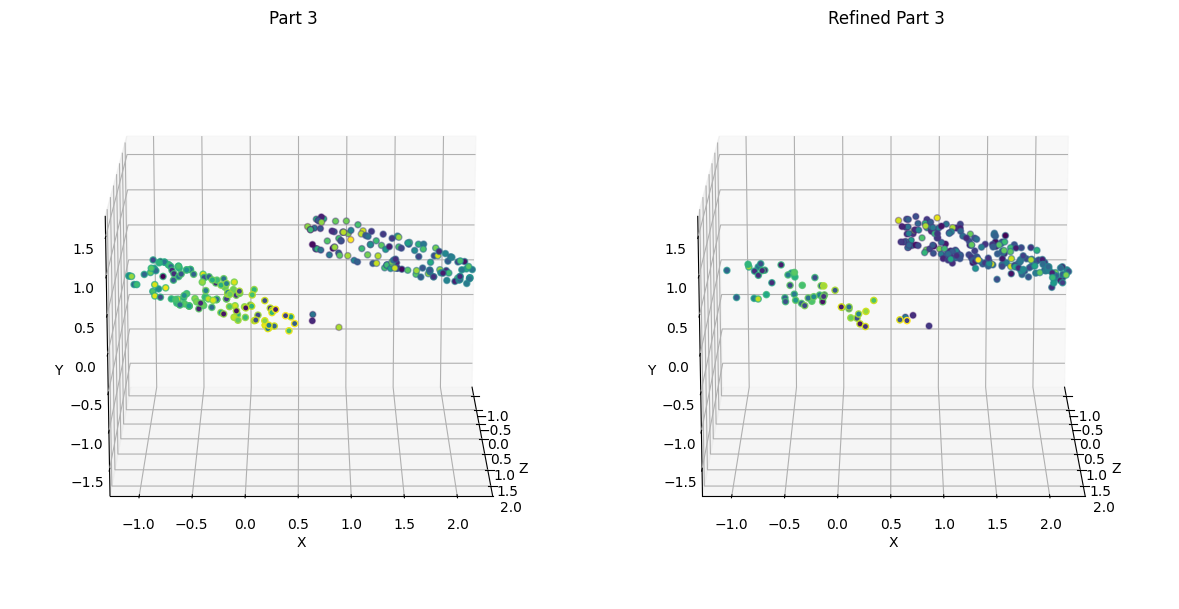

In [52]:
input_part_seg = input_seg[INDEX, ...]

# One hot encoded
class_labels_one_hot = F.one_hot(input_part_seg, num_classes=4)
combined_tensor = torch.cat((input[INDEX, ...], class_labels_one_hot), dim=-1)
output_part = model(combined_tensor.unsqueeze(0).transpose(1,2)).transpose(1,2).squeeze(0)

for i in range(input_part_seg.max()+1):
    refined_np = rotate_point_cloud_y(output_part[input_part_seg == i].detach().cpu().numpy(), 45)
    pc_part = rotate_point_cloud_y(input[INDEX, input_part_seg == i, ...].detach().cpu().numpy(), 45)
    print(pc_part.shape, np.linalg.norm(pc_part - refined_np))

    fig = visualize_pointcloud_eval(pc_part, refined_np, f"Part {i}", f"Refined Part {i}")

In [53]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [54]:
input_array = []

for batch in val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [61]:
# Evaluation
output_array = []

model.eval()
with torch.no_grad():
    for batch in dataloader_pvd:
        input = batch["test_points"].to("cuda")
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((input, class_labels_one_hot), dim=-1)
        output = model(combined_tensor.transpose(1,2)).transpose(1,2)
        output_array.append(output)
        

In [64]:
input_pcs = torch.stack(input_array).view(400, 2048, 3)
output_pcs = torch.stack(output_array).view(400, 2048, 3)
input_pcs.shape, output_pcs.shape

(torch.Size([400, 2048, 3]), torch.Size([400, 2048, 3]))

In [66]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]

{'lgan_mmd-CD': 0.07427497208118439, 'lgan_cov-CD': 0.3149999976158142, 'lgan_mmd_smp-CD': 0.02809010073542595, 'lgan_mmd-EMD': 0.6196457147598267, 'lgan_cov-EMD': 0.3149999976158142, 'lgan_mmd_smp-EMD': 0.3524820804595947, '1-NN-CD-acc_t': 0.8949999809265137, '1-NN-CD-acc_f': 0.9700000286102295, '1-NN-CD-acc': 0.9325000047683716, '1-NN-EMD-acc_t': 0.8424999713897705, '1-NN-EMD-acc_f': 0.9225000143051147, '1-NN-EMD-acc': 0.8824999928474426}


In [ ]:
result = {
    'lgan_mmd-CD': 0.07427497208118439, 
    'lgan_cov-CD': 0.3149999976158142, 
    'lgan_mmd_smp-CD': 0.02809010073542595, 
    'lgan_mmd-EMD': 0.6196457147598267, 
    'lgan_cov-EMD': 0.3149999976158142, 
    'lgan_mmd_smp-EMD': 0.3524820804595947, 
    '1-NN-CD-acc_t': 0.8949999809265137, 
    '1-NN-CD-acc_f': 0.9700000286102295, 
    '1-NN-CD-acc': 0.9325000047683716, 
    '1-NN-EMD-acc_t': 0.8424999713897705, 
    '1-NN-EMD-acc_f': 0.9225000143051147, 
    '1-NN-EMD-acc': 0.8824999928474426
}
